In [1]:
import scvi
import os
import tempfile
import scanpy as sc
import scarches as sca
import seaborn as sns
import torch
import pandas as pd
from rich import print
import numpy as np
import matplotlib.pyplot as plt
import skmisc

/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


In [2]:
scvi.settings.seed = 42
torch.set_float32_matmul_precision('high')

[rank: 0] Seed set to 42


In [46]:
adata = sc.read("/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/2_6_tumour_only_anno/GL0128_tumour.h5ad")
adata

AnnData object with n_obs × n_vars = 550 × 5000
    obs: 'bc_wells', 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'bc1_well', 'bc2_well', 'bc3_well', 'doublet_score', 'predicted_doublets', 'sum', 'detected', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'total', 'low_lib_size', 'low_n_features', 'high_subsets_mito_percent', 'discard', 'discard_mito', 'discard_feature', 'discard_final', 'sizeFactor', 'leiden_individual', 'X_scvi_batch', 'X_scvi_labels', 'leiden', 'line', 'type', 'couturier_cell_label', 'couturier_cluster_label'
    var: 'gene_id', 'gene_name', 'genome', 'gene_version', 'gene_source', 'gene_biotype', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'X_name', 'X_scvi_manager_uuid', 'X_scvi_uuid', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'sample_colors'
    obsm: 'X_scVI', 'X_scVI_MDE'
    layers: 'logcounts'
    obsp: 'connectivities', 'distances'

In [47]:
sc.pp.highly_variable_genes(
    adata = adata, 
    flavor = "seurat_v3",
    n_top_genes = 5000, 
    subset = True
)

In [48]:
# integration with scVI
scvi.model.SCVI.setup_anndata(
    adata = adata, 
    batch_key = "sample"
)
# create model
scvi_model = scvi.model.SCVI(
    adata = adata,
    n_hidden = 128,
    n_latent = 50,
    dispersion = "gene-batch"
)
# train model
# scvi.settings.dl_num_workers = 15
scvi_model.train(
    max_epochs = 1000, 
    early_stopping = True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/lightning/pytorch/trainer/conne

Epoch 222/1000:  22%|██▏       | 222/1000 [00:08<00:30, 25.51it/s, v_num=1, train_loss_step=2.44e+3, train_loss_epoch=2.41e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 2703.064. Signaling Trainer to stop.


In [49]:
# train_test_results = scvi_model.history["elbo_train"]
# train_test_results["elbo_validation"] = scvi_model.history["elbo_validation"]
# train_test_results.iloc[10:].plot(logy = True)  # exclude first 10 epochs
# plt.show()

In [50]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = scvi_model.get_latent_representation()

In [51]:
sc.pp.neighbors(
    adata = adata, 
    use_rep = SCVI_LATENT_KEY, 
    n_neighbors = 15,
    n_pcs = 50,
    method = "gauss",
    knn = False
)
# sc.tl.umap(
#     adata = adata, 
#     min_dist = 0.005
# )

In [52]:
sc.tl.leiden(
    adata,
    flavor = "igraph",
    resolution = 1.25,
    # n_iterations = 10
)

In [53]:
SCVI_MDE_KEY = "X_scVI_MDE"
adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCVI_LATENT_KEY])

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


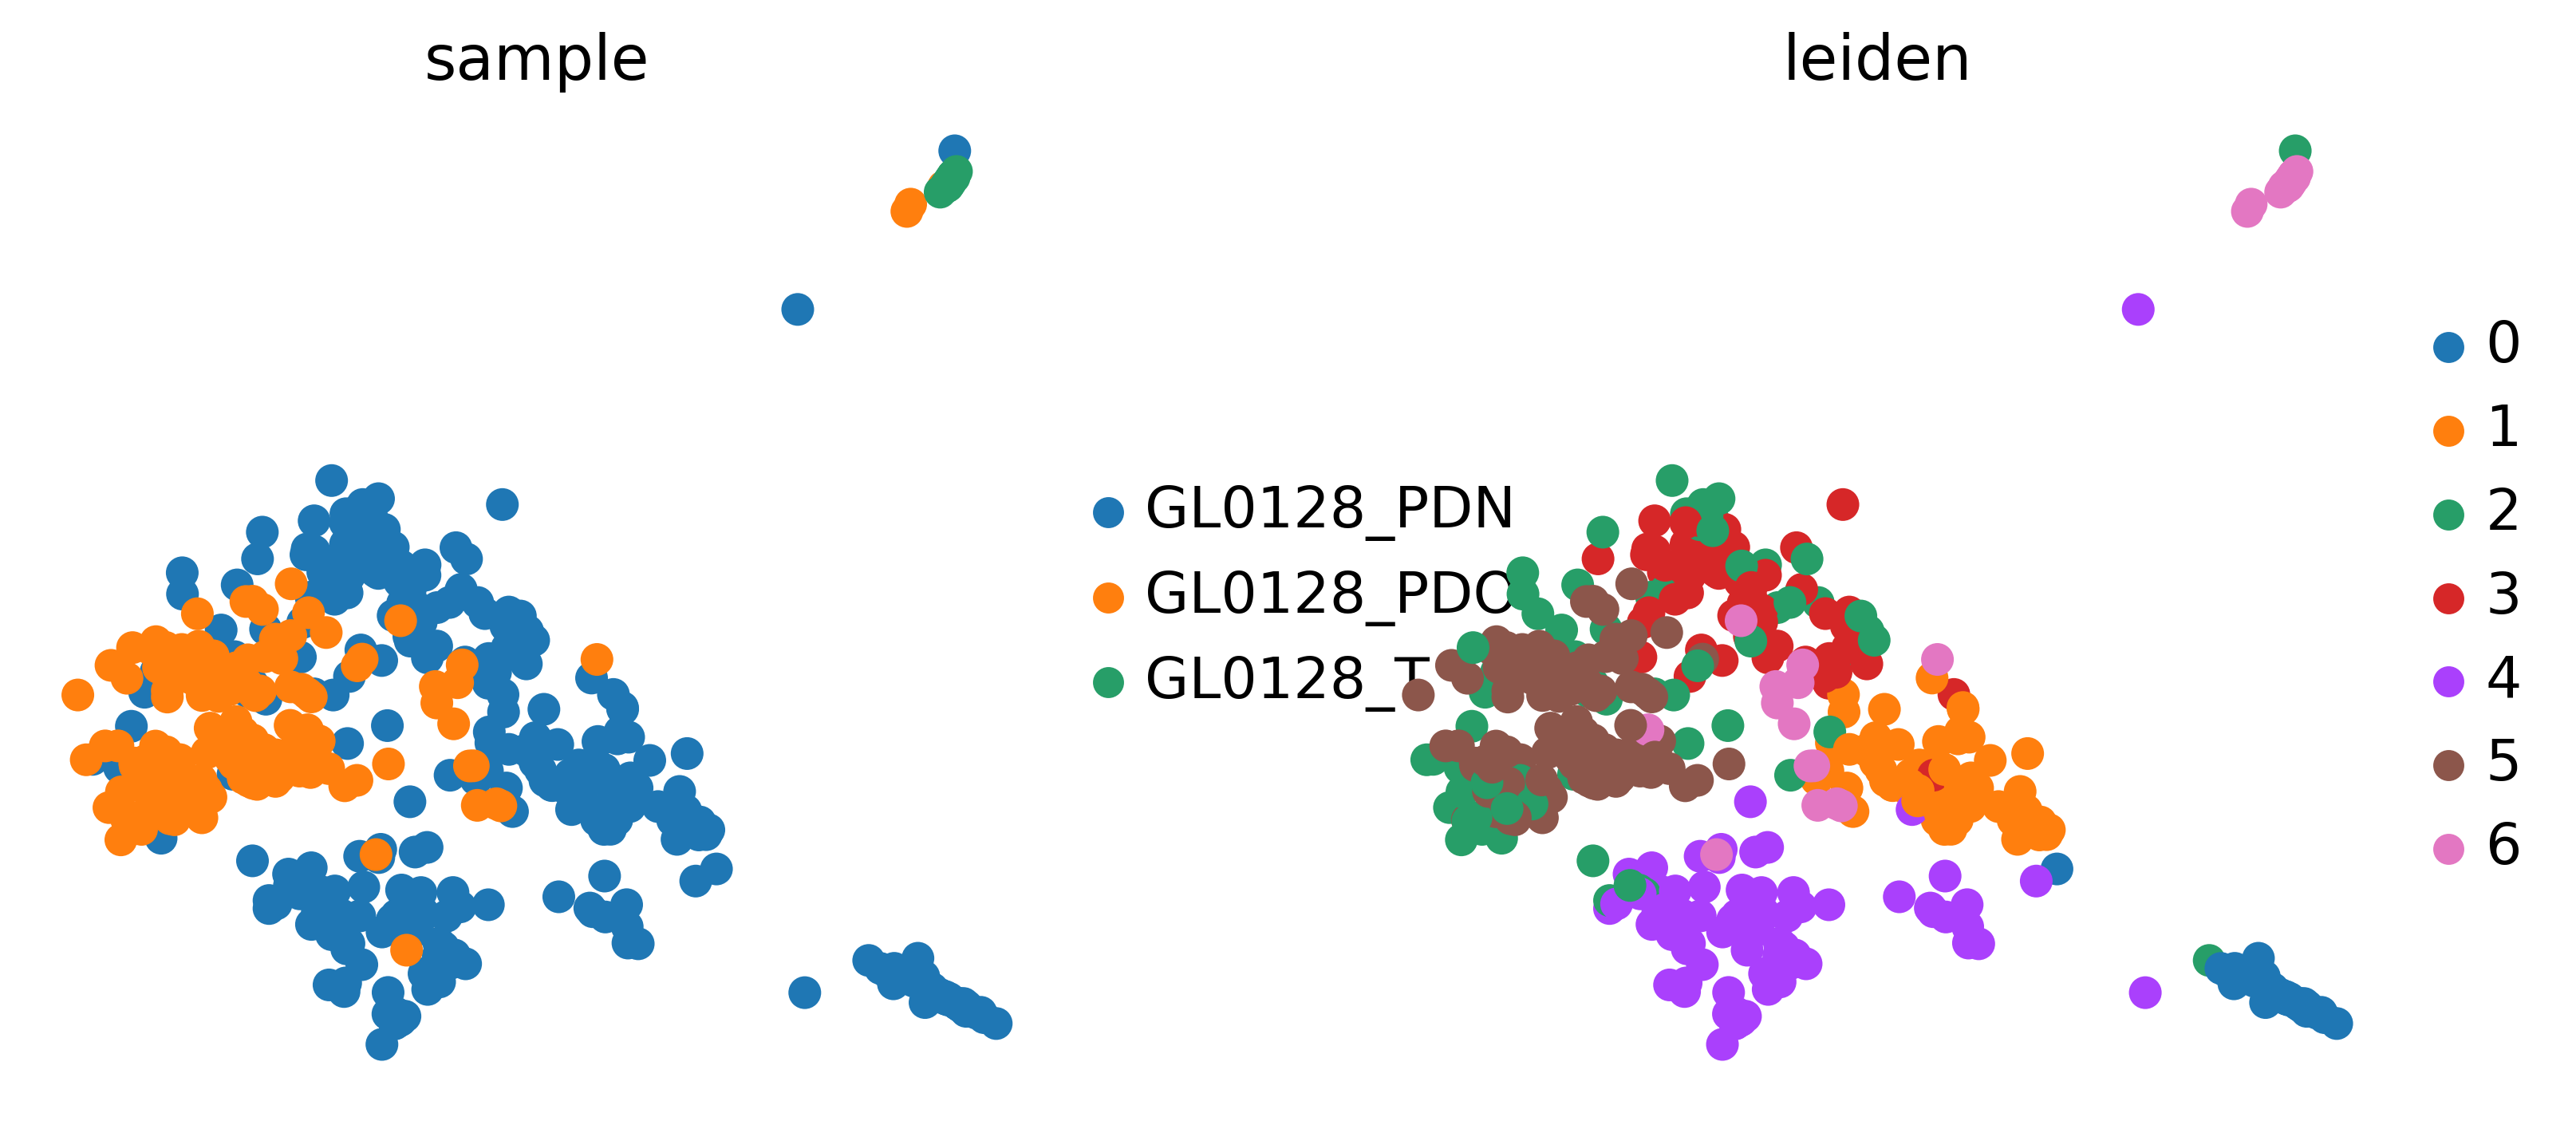

In [54]:
sc.pl.embedding(
    adata = adata,
    basis = SCVI_MDE_KEY,
    color = ["sample", "leiden"],
    # legend_loc = "on data",
    frameon = False,
    ncols = 2
)

In [ ]:
sc.pl.embedding(
    adata = adata,
    basis = SCVI_MDE_KEY,
    color = ["couturier_cell_label", "couturier_cluster_label"],
    # legend_loc = "on data",
    frameon = False,
    ncols = 2
)

In [56]:
per_anno_pdo_tis = pd.DataFrame()
for i in list(adata.obs["couturier_cell_label"].unique()):
    
    idx_1 = (adata.obs["type"] == "PDO") & (adata.obs["couturier_cell_label"] == i)
    idx_2 = (adata.obs["type"] == "T") & (adata.obs["couturier_cell_label"] == i)
    
    if not any(idx_1) or not any(idx_2):
        continue
    
    res_pdo_tis = scvi_model.differential_expression(
        adata = adata, 
        idx1 = idx_1,
        idx2 = idx_2,
        filter_outlier_cells = False,
        batch_correction = False
    )
    
    res_pdo_tis.insert(0, "couturier_cell_label", i)
    
    per_anno_pdo_tis = pd.concat([per_anno_pdo_tis, res_pdo_tis])
    
per_anno_pdn_tis = pd.DataFrame()
for i in list(adata.obs["couturier_cell_label"].unique()):
    
    idx_1 = (adata.obs["type"] == "PDN") & (adata.obs["couturier_cell_label"] == i)
    idx_2 = (adata.obs["type"] == "T") & (adata.obs["couturier_cell_label"] == i)
    
    if not any(idx_1) or not any(idx_2):
        continue
    
    res_pdn_tis = scvi_model.differential_expression(
        adata = adata, 
        idx1 = idx_1,
        idx2 = idx_2,
        filter_outlier_cells = False,
        batch_correction = False
    )
    
    res_pdn_tis.insert(0, "couturier_cell_label", i)
    
    per_anno_pdn_tis = pd.concat([per_anno_pdn_tis, res_pdn_tis])
per_anno_pdn_pdo = pd.DataFrame()
for i in list(adata.obs["couturier_cell_label"].unique()):
    
    idx_1 = (adata.obs["type"] == "PDN") & (adata.obs["couturier_cell_label"] == i)
    idx_2 = (adata.obs["type"] == "PDO") & (adata.obs["couturier_cell_label"] == i)
    
    if not any(idx_1) or not any(idx_2):
        continue
    
    res_pdn_pdo = scvi_model.differential_expression(
        adata = adata, 
        idx1 = idx_1,
        idx2 = idx_2,
        filter_outlier_cells = False,
        batch_correction = False
    )
    
    res_pdn_tis.insert(0, "couturier_cell_label", i)
    
    per_anno_pdn_pdo = pd.concat([per_anno_pdn_pdo, res_pdn_pdo])

DE...: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


In [57]:
per_anno_pdn_tis

,couturier_cell_label,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05
ENSG00000001626,Oligo,1.0000,0.0000,18.420681,0.000008,0.000955,0.0,0.25,-7.472257,-7.406159,1.555362,-11.992534,-2.928852,0.000000,0.285714,0.000000,0.285714,0.000000,6.730781,True
ENSG00000183775,Oligo,1.0000,0.0000,18.420681,0.000064,0.000498,0.0,0.25,-3.211682,-3.158890,1.005442,-7.331794,-0.466922,0.072464,0.142857,0.057971,0.142857,0.184609,5.494505,True
ENSG00000105974,Oligo,1.0000,0.0000,18.420681,0.000010,0.000273,0.0,0.25,-5.330265,-5.248806,1.509251,-11.277656,-0.656201,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,True
ENSG00000183166,Oligo,1.0000,0.0000,18.420681,0.000054,0.001074,0.0,0.25,-4.674979,-4.658964,1.173699,-9.098787,-0.806628,0.086957,0.571429,0.043478,0.571429,0.155890,18.549944,True
ENSG00000106526,Oligo,1.0000,0.0000,18.420681,0.000016,0.000250,0.0,0.25,-4.354921,-4.279284,1.249062,-8.037379,-0.725101,0.014493,0.000000,0.014493,0.000000,0.050200,0.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000139132,Unassigned,0.6748,0.3252,0.729976,0.000439,0.000423,0.0,0.25,-0.042374,-0.041717,0.584652,-1.784322,1.466890,3.962963,0.000000,0.740741,0.000000,4.238443,0.000000,False
ENSG00000141447,Unassigned,0.6688,0.3312,0.702763,0.000467,0.000355,0.0,0.25,0.334131,0.308700,0.494775,-1.141099,1.824596,4.592593,0.000000,0.814815,0.000000,4.279865,0.000000,False
ENSG00000100412,Unassigned,0.6650,0.3350,0.685656,0.000325,0.000291,0.0,0.25,-0.019208,-0.034835,0.761441,-2.413123,2.388531,3.444444,1.000000,0.777778,1.000000,3.424679,18.248175,False
ENSG00000138709,Unassigned,0.6636,0.3364,0.679379,0.000229,0.000283,0.0,0.25,-0.410941,-0.289996,0.641810,-2.272876,1.035176,1.777778,0.000000,0.703704,0.000000,2.097756,0.000000,False


In [58]:
per_anno_pdo_tis.to_csv("/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/2_7_tumour_deg_anno/GL0128_pdo.csv")
per_anno_pdn_tis.to_csv("/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/2_7_tumour_deg_anno/GL0128_pdn.csv")

In [16]:
# per_anno_pdo_tis.insert(1, "couturier_cell_label", i)
# per_anno_pdo_tis